In [1]:
#!/usr/bin/env python
"""Mixture model using variational inference.
We posit a collapsed mixture of Gaussians.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf

from edward.models import Dirichlet, Normal, InverseGamma
from edward.stats import dirichlet, invgamma, multivariate_normal_diag, norm
from edward.util import get_dims

plt.style.use('ggplot')

/home/folzd/anaconda3/lib/python3.5/site-packages/edward/stats/distributions.py:22: DeprecationWarning: edward.stats is deprecated. If calling rvs() from the distribution, use scipy.stats; if calling density methods from the distribution, use edward.models.
  DeprecationWarning)


In [2]:
class MixtureGaussian:
  """
  Mixture of Gaussians
  p(x, z) = [ prod_{n=1}^N sum_{k=1}^K pi_k N(x_n; mu_k, sigma_k) ]
            [ prod_{k=1}^K N(mu_k; 0, cI) Inv-Gamma(sigma_k; a, b) ]
            Dirichlet(pi; alpha)
  where z = {pi, mu, sigma} and for known hyperparameters a, b, c, alpha.
  Parameters
  ----------
  K : int
    Number of mixture components.
  D : float, optional
    Dimension of the Gaussians.
  """
  def __init__(self, K, D):
    self.K = K
    self.D = D
    self.n_vars = (2 * D + 1) * K

    self.a = 1.0
    self.b = 1.0
    self.c = 3.0
    self.alpha = tf.ones([K])

  def log_prob(self, xs, zs):
    """Return scalar, the log joint density log p(xs, zs)."""
    x = xs['x']
    pi, mus, sigmas = zs['pi'], zs['mu'], zs['sigma']
    log_prior = dirichlet.logpdf(pi, self.alpha)
    log_prior += tf.reduce_sum(norm.logpdf(mus, 0.0, self.c))
    log_prior += tf.reduce_sum(invgamma.logpdf(sigmas, self.a, self.b))

    # log-likelihood is
    # sum_{n=1}^N log sum_{k=1}^K exp( log pi_k + log N(x_n; mu_k, sigma_k) )
    # Create a K x N matrix, whose entry (k, n) is
    # log pi_k + log N(x_n; mu_k, sigma_k).
    N = get_dims(x)[0]
    matrix = []
    for k in range(self.K):
      matrix += [tf.ones(N) * tf.log(pi[k]) +
                 multivariate_normal_diag.logpdf(x,
                 mus[(k * self.D):((k + 1) * self.D)],
                 sigmas[(k * self.D):((k + 1) * self.D)])]

    matrix = tf.stack(matrix)
    # log sum exp along the rows is a vector, whose nth
    # element is the log-likelihood of data point x_n.
    vector = tf.reduce_logsumexp(matrix, 0)
    # Sum over data points to get the full log-likelihood.
    log_lik = tf.reduce_sum(vector)

    return log_prior + log_lik

  def predict(self, xs, zs):
    """Calculate a K x N matrix of log-likelihoods, per-cluster and
    per-data point."""
    x = xs['x']
    pi, mus, sigmas = zs['pi'], zs['mu'], zs['sigma']

    matrix = []
    for k in range(self.K):
      matrix += [multivariate_normal_diag.logpdf(x,
                 mus[(k * self.D):((k + 1) * self.D)],
                 sigmas[(k * self.D):((k + 1) * self.D)])]

    return tf.stack(matrix)


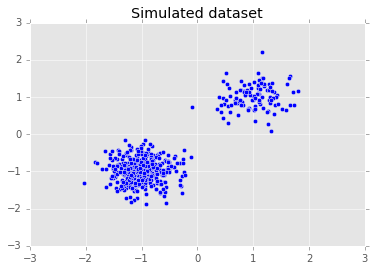

In [3]:
def build_toy_dataset(N):
  pi = np.array([0.2, 0.8])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x


ed.set_seed(42)
x_train = build_toy_dataset(500)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

In [4]:
K = 2
D = 2
model = MixtureGaussian(K, D)

qpi_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K])))
qmu_mu = tf.Variable(tf.random_normal([K * D]))
qmu_sigma = tf.nn.softplus(tf.Variable(tf.random_normal([K * D])))
qsigma_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K * D])))
qsigma_beta = tf.nn.softplus(tf.Variable(tf.random_normal([K * D])))

qpi = Dirichlet(alpha=qpi_alpha)
qmu = Normal(mu=qmu_mu, sigma=qmu_sigma)
qsigma = InverseGamma(alpha=qsigma_alpha, beta=qsigma_beta)

data = {'x': x_train}
inference = ed.KLqp({'pi': qpi, 'mu': qmu, 'sigma': qsigma}, data, model)


/home/folzd/anaconda3/lib/python3.5/site-packages/edward/inferences/inference.py:182: DeprecationWarning: Model wrappers are deprecated. Edward is dropping support for model wrappers in future versions; use the native language instead.
  "native language instead.", DeprecationWarning)


In [6]:
inference.initialize()

In [7]:
variables = [qpi_alpha, qmu_mu, qmu_sigma, qsigma_alpha, qsigma_beta, qpi, qmu, qsigma]

In [8]:
init = tf.variables_initializer([qmu_mu])

In [9]:
init = tf.global_variables_initializer()
#init = tf.initialize_all_variables()

In [10]:
init.run()

In [12]:
inference.coord = tf.train.Coordinator()

In [15]:
for _ in range(1000):
    inference.print_progress(inference.update())

TypeError: update() got an unexpected keyword argument 'n_samples'

In [5]:
inference.run(n_iter=3000, n_samples=10, n_minibatch=8)

Iteration    1 [  0%]: Loss = 107.470
Iteration  300 [ 10%]: Loss = 32.794
Iteration  600 [ 20%]: Loss = 31.293
Iteration  900 [ 30%]: Loss = 37.356
Iteration 1200 [ 40%]: Loss = 29.150
Iteration 1500 [ 50%]: Loss = 22.912
Iteration 1800 [ 60%]: Loss = 28.811
Iteration 2100 [ 70%]: Loss = 22.273
Iteration 2400 [ 80%]: Loss = 31.390
Iteration 2700 [ 90%]: Loss = 34.475
Iteration 3000 [100%]: Loss = 24.138


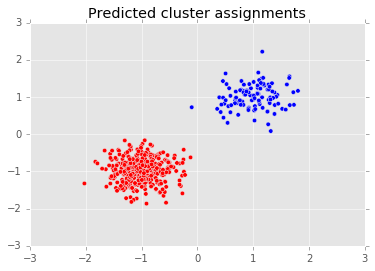

In [6]:
# Average per-cluster and per-data point likelihood over many posterior samples.
log_liks = []
for s in range(100):
  zrep = {'pi': qpi.sample(()),
          'mu': qmu.sample(()),
          'sigma': qsigma.sample(())}
  log_liks += [model.predict(data, zrep)]

log_liks = tf.reduce_mean(log_liks, 0)

# Choose the cluster with the highest likelihood for each data point.
clusters = tf.argmax(log_liks, 0).eval()
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [7]:
# true value is 0.8, 0.2
qpi.mean().eval()

array([ 0.34525594,  0.65474409], dtype=float32)